# <span style="color: navy"> Project #2 – DS Tools </span>

### <span style="color: navy"> Background </span>

In this project we will explore and visualize some facts about mountains and peaks around the world.  
The project is entirely based on the data available in the site PeakWare.com,  
which entitles itself as the “World Mountain Encyclopedia”.

# <span style="color: green">Part II – Data exploration</span> 

In [33]:
import re
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from time import time
from datetime import datetime

from mpl_toolkits.basemap import Basemap
# import networkx as nx

matplotlib.style.use('ggplot')

# %matplotlib inline
%matplotlib notebook
# i use the notebook parameter instead of in line in order to zoom in the graphs using matplotlib
from os import getcwd
pd.set_option('notebook_repr_html', True)

#### Jupyter will display all variable without the need for a print statement and not only the last

In [34]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [35]:
# this limit the column width
pd.options.display.max_colwidth = 20
# this controls the floating rounding (precision, keep 2 decimals after .)
pd.options.display.precision =2

In [140]:
peaks_df = pd.read_csv('peaks.csv',index_col=0,header=0, na_values=['\n'])

### 1. How many countries are listed

In [141]:
peaks_df.loc[peaks_df.country.notnull(),'country'].nunique()
# .value_counts().to_csv('country.csv', encoding='utf-8') 

125

### 2. Which mountains from Israel are listed?

In [142]:
peaks_df[peaks_df.country == 'Israel']
# % timeit peaks_df.groupby('country').get_group('Israel') 858 vs 655

,peak_code,name_of_peak,elevation_feet,elevation_meters,continent,country,state,province,range/region,latitude,longitude,difficulty,best_months_for_climbing,year_first_climbed,first_successful_climbers,nearest_major_airport,convenient_center,volcanic_status,most_recent_eruption
row_num,,,,,,,,,,,,,,,,,,,
151,38,Mount Carmel,1791.0,546.0,Asia,Israel,NaN,NaN,Sinai-Palestine ...,32.73,35.05,Walk Up,"Apr, May, Jun",NaN,NaN,"Tel Aviv, Israel","Haifa, Israel",NaN,NaN
400,4295,Masada,1509.0,460.0,Asia,Israel,NaN,NaN,NaN,31.32,35.35,NaN,"Jan, Feb, Mar, A...",NaN,NaN,Tel Aviv,Jerusalem,NaN,NaN
412,3856,Har Meron,3963.0,1208.0,Asia,Israel,NaN,NaN,NaN,33.00,35.41,Walk Up,"Jan, Feb, Mar, A...",NaN,NaN,Tel Aviv,Tel Aviv,NaN,NaN


### 3. Make a histogram of the peaks heights in Europe.

<IPython.core.display.Javascript object>


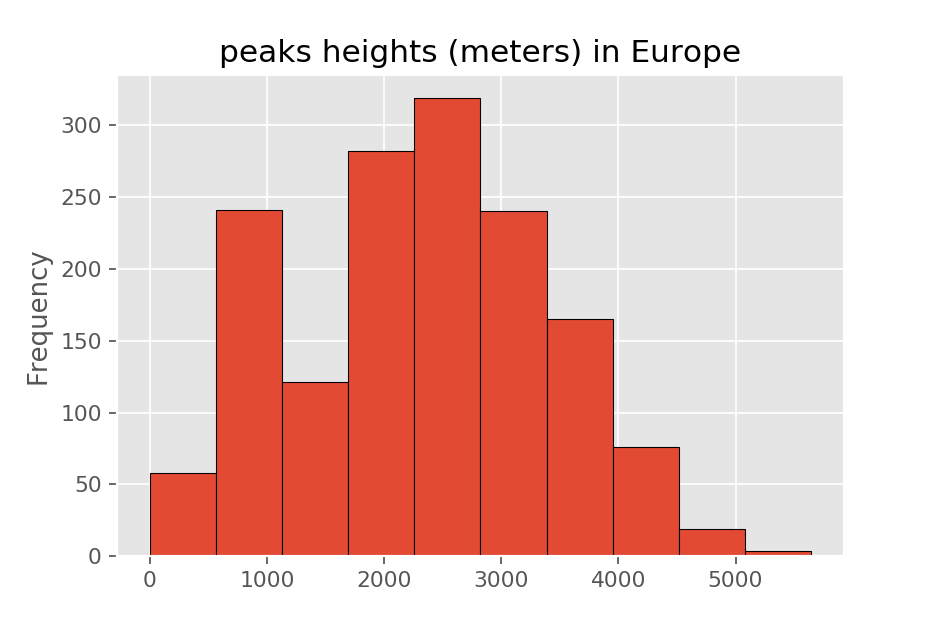

In [144]:
# peaks_df[peaks_df.continent=='Asia'].elevation_meters.plot(kind='hist', title='peaks heights (meters) in Asia',edgecolor='black')
fig1= plt.figure(figsize=(6,4))
peaks_df[peaks_df.continent=='Europe'].elevation_meters.plot(kind='hist', title='peaks heights (meters) in Europe',edgecolor='black')

### 4. Which country has the highest number of peaks above 6000m?

In [145]:
peaks_df.loc[peaks_df.elevation_meters>6000,'country'].value_counts().head(1)

Nepal    63
Name: country, dtype: int64

### 5. Make a pie chart for the number of peaks in each continent.

<IPython.core.display.Javascript object>


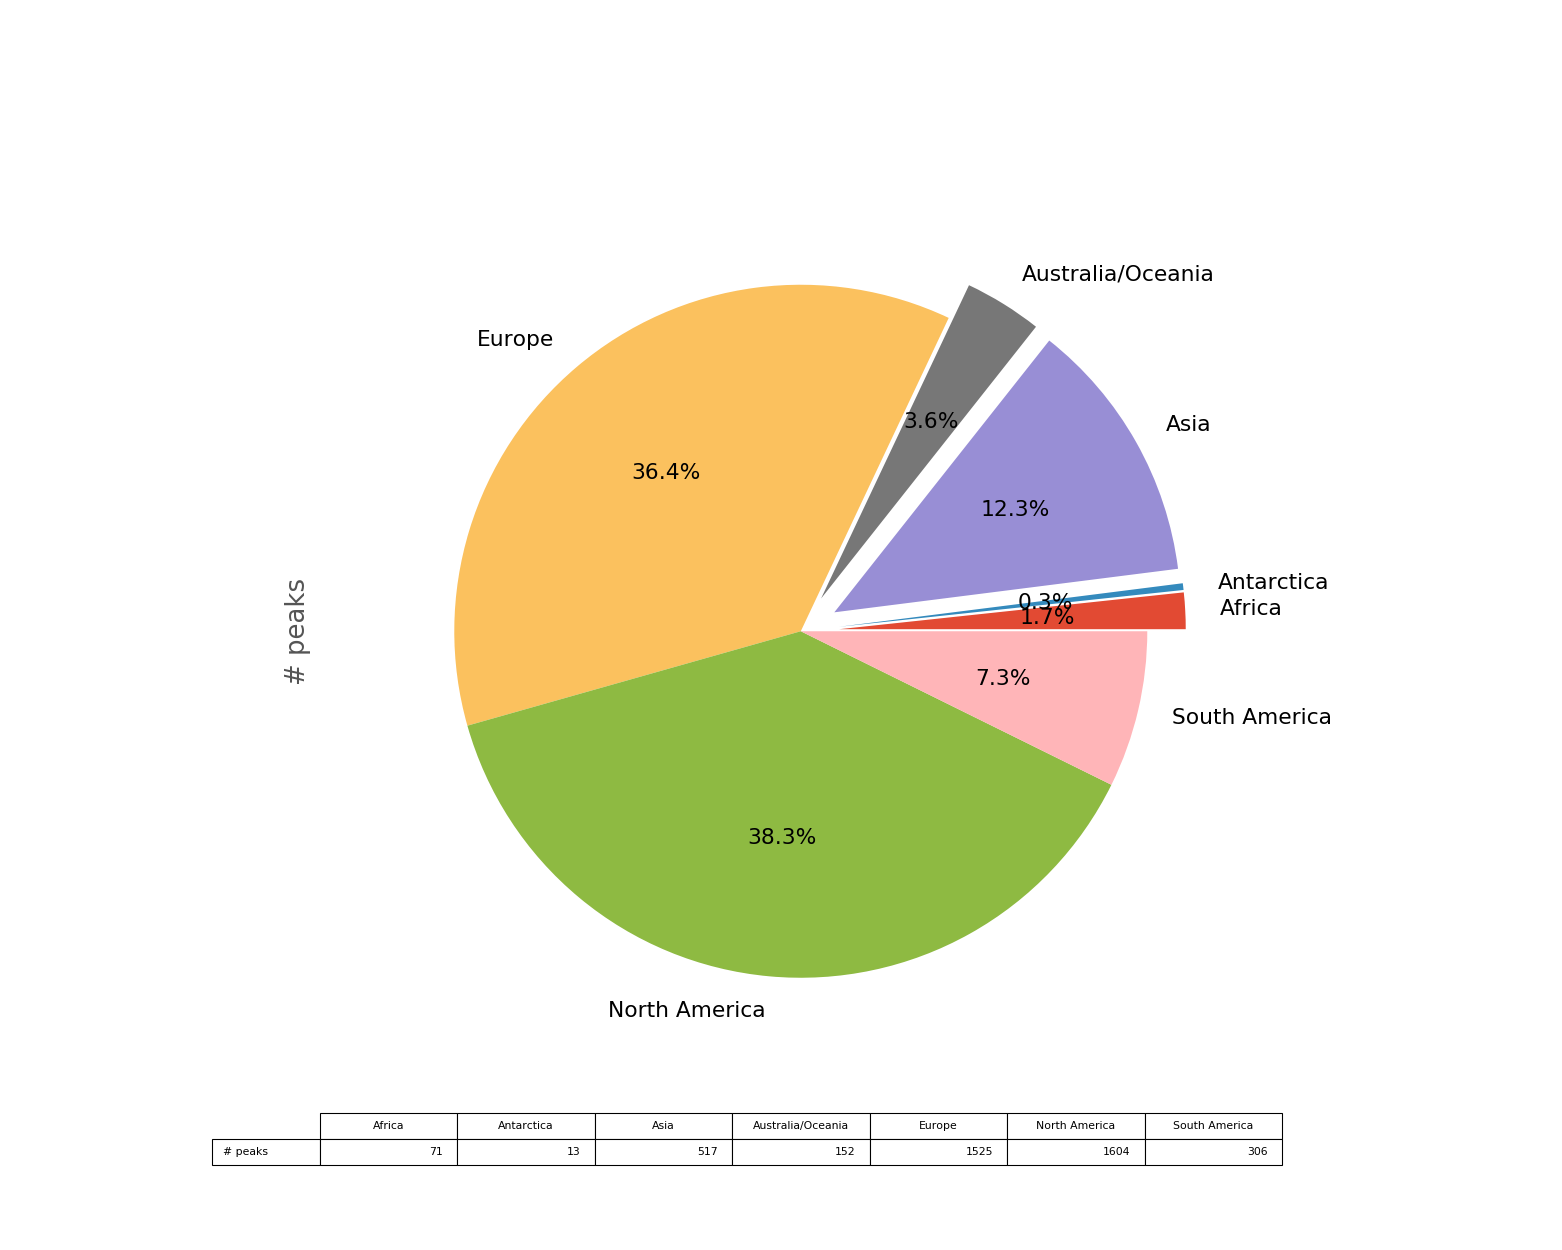

In [172]:
# from pandas.plotting import table
#  print(plt.style.available)
continent_series = pd.Series(peaks_df.groupby('continent').peak_code.count(), name='# peaks')

fig2= plt.figure(figsize=(10,8))
# plot chart
# aspect='equal'
ax1 = plt.subplot(111,aspect='equal')
#                   autoscale_on=False,aspect='equal' )
continent_series.plot(kind = 'pie',ax = ax1,startangle = 0 ,shadow = False\
                      ,legend = False,autopct = '%1.1f%%', fontsize = 10\
                      ,radius = 0.9,table = True,explode = (0.1,0.1,0.1,0.1,0,0,0))

plt.show()

### 6. Sort the continents by their average peak height.

In [174]:
peaks_df.groupby('continent')['elevation_meters'].mean().sort_values(ascending=False)

# %timeit peaks_df.groupby('continent').agg({'elevation_meters' :['mean']})\
# .sort_values(('elevation_meters','mean'),ascending=False)  
# 668 µs vs  1.67 ms per loop

continent
Asia                 4769.25
South America        4409.00
Africa               3227.72
North America        2573.74
Antarctica           2546.23
Europe               2323.86
Australia/Oceania    1840.09
Name: elevation_meters, dtype: float64

### 7. Find the highest mountain in each continent.

In [175]:
continent_max_peak = peaks_df.groupby('continent').elevation_meters.max().to_frame()
pd.merge(continent_max_peak, peaks_df,how='inner')

,elevation_meters,peak_code,name_of_peak,elevation_feet,continent,country,state,province,range/region,latitude,longitude,difficulty,best_months_for_climbing,year_first_climbed,first_successful_climbers,nearest_major_airport,convenient_center,volcanic_status,most_recent_eruption
0,5895.0,139,Mount Kilimanjaro,19340.0,Africa,Tanzania,NaN,NaN,Northeast Tanzania,-3.07,37.35,Walk Up,"Jan, Feb, Mar, J...",1889.0,"Hans Meyer, L. P...",Kilimanjaro Inte...,Marangu via Mosh...,NaN,NaN
1,4897.0,994,Vinson Massif,16066.0,Antarctica,Antarctica,NaN,NaN,Ellsworth Mountains,-78.58,-85.42,Major Mountain E...,"Jan, Dec",1966.0,American Expedit...,NaN,Two permanent re...,NaN,NaN
2,8850.0,80,Mount Everest,29035.0,Asia,Nepal,NaN,NaN,Central Nepal Hi...,27.99,86.93,Major Mountain E...,"Apr, May",1953.0,"Edmund Hillary, ...","Kathmandu, Nepal","Namche Bazar, Nepal",NaN,NaN
3,4884.0,333,Puncak Jaya,16023.0,Australia/Oceania,Indonesia,NaN,NaN,Maoke Range,-4.08,137.18,Scramble,"Feb, Apr, May, J...",1962.0,"Heinrich Harrer,...",Nabire,Nabire,NaN,NaN
4,5642.0,1059,Mount Elbrus,18510.0,Europe,Russia,NaN,NaN,Central Caucasus,43.35,42.44,Basic Snow/Ice C...,"Jun, Jul, Aug, Sep",1874.0,"A. W. Moore, F. ...","Moscow, Russia, ...",Mineral'nye Vody...,NaN,NaN
5,6194.0,174,Denali,20320.0,North America,United States,Alaska,NaN,Alaska Range,63.07,-151.00,Major Mountain E...,"Apr, May, Jun",1913.0,"Hudson Stuck, Ha...","Anchorage, Alaska","Talkeetna, Alaska",NaN,NaN
6,6962.0,1895,Aconcagua,22841.0,South America,Argentina,NaN,NaN,Central Argentin...,-32.65,-70.01,Major Mountain E...,"Jan, Feb, Mar",1897.0,Matthias Zurbriggen,"Mendoza, Argentina","Mendoza, Argentina",NaN,NaN


### 8. How many peaks are in “islands” countries? which is the highest of them?

In [176]:
islands_peaks =peaks_df.loc[peaks_df.country.str.contains("islands", case=False)==True][['name_of_peak','elevation_meters']].sort_values('elevation_meters' ,ascending=False)
print "There are {} peaks , and the highest is : {}".format(len(islands_peaks), islands_peaks.name_of_peak.iloc[0])

There are 4 peaks , and the highest is : Mt Popomaneseu


### 9a. Which country has the largest number of peaks listed? 

In [177]:
 peaks_df.groupby('country').name_of_peak.count().sort_values(ascending=False)[[0]]

country
United States    1249
Name: name_of_peak, dtype: int64

### 9b. And per continent?

In [178]:
peaks_df.groupby('continent')['country'].value_counts().unstack().idxmax(axis=1)
# %timeit peaks_df.groupby('continent')['country'].value_counts().unstack().apply(lambda x: x.argmax(), axis=1)  
# 1.98 ms vs 2.32 ms per loop

continent
Africa                South Africa
Antarctica              Antarctica
Asia                         Nepal
Australia/Oceania        Australia
Europe                       Italy
North America        United States
South America            Argentina
dtype: object

### 10. What is the first mountain that was climbed in each century?

In [182]:
century_peaks =  peaks_df[['peak_code','name_of_peak','year_first_climbed']].loc[peaks_df.year_first_climbed.notnull()]
century_peaks.year_first_climbed = century_peaks.year_first_climbed.map(lambda x: int(str(x)[:-2]))
century_peaks ['century']= century_peaks.year_first_climbed.map(lambda x: int(str(x)[:-2])+1)
century_peaks.loc[century_peaks.groupby('century').year_first_climbed.idxmin(axis=0)]

,peak_code,name_of_peak,year_first_climbed,century
row_num,,,,
2915,595,Haleakala,600,7
4020,1863,Huanya Picchu,1200,13
2726,747,Eagle Cap,1300,14
787,4,Mont Aiguille,1492,15
1910,3874,Roseberry Topping,1500,16
3825,1988,West Spanish Peak,1600,17
2384,4224,Bear Butte,1743,18
761,2334,Agios Bernados,1800,19
830,2448,Bålleberget,1900,20


### 11. Of all the peaks with climbing difficulty “walk up”, which is the highest?

In [183]:
peaks_df.loc[[peaks_df.groupby('difficulty').get_group('Walk Up').elevation_feet.argmax()]]
#  1.62 ms per loop

# %timeit peaks_df.loc[peaks_df.difficulty.str.contains("walk Up", case=False)==True][['name_of_peak','elevation_meters']]\
# .sort_values('elevation_meters' ,ascending=False).head(1) 
# 4.38 ms per loop
# %timeit peaks_df.loc[[peaks_df.loc[peaks_df.difficulty.str.contains("walk Up", case=False)==True].elevation_meters.argmax()]]
#  4.02 ms per loop
# peaks_df.difficulty.to_csv('difficulty.csv', encoding='utf-8') 

,peak_code,name_of_peak,elevation_feet,elevation_meters,continent,country,state,province,range/region,latitude,longitude,difficulty,best_months_for_climbing,year_first_climbed,first_successful_climbers,nearest_major_airport,convenient_center,volcanic_status,most_recent_eruption
row_num,,,,,,,,,,,,,,,,,,,
262,2812,Haramosh Peak,24308.0,7409.0,Asia,Pakistan,NaN,NaN,Karakoram,35.84,74.9,Walk Up,"Jun, Jul, Aug",1958.0,Austrians and fr...,gilgit northern ...,heramosh,NaN,NaN


### 12. How many peaks are there on the equator (no more than 1 degree away from it?)

In [184]:
peaks_df.loc[peaks_df.latitude.abs()<=1].name_of_peak.count()

28

### 13. Find the highest peak for each combination of continent and difficulty.

In [185]:
continent_diff_s = peaks_df.groupby(['continent','difficulty'])['elevation_meters'].idxmax(axis=0)
peaks_df[['continent','difficulty','name_of_peak','elevation_meters']].loc[continent_diff_s]\
.sort_values(['continent','difficulty'] )
# .to_csv('continent_and_difficulty.csv', encoding='utf-8') 

,continent,difficulty,name_of_peak,elevation_meters
row_num,,,,
42,Africa,Basic Snow/Ice C...,Margherita,5109.0
44,Africa,Scramble,Mawenzi,5149.0
30,Africa,Technical Climb,Mount Kenya,5199.0
31,Africa,Walk Up,Mount Kilimanjaro,5895.0
73,Antarctica,Basic Snow/Ice C...,Mount Erebus,3794.0
83,Antarctica,Major Mountain E...,Vinson Massif,4897.0
77,Antarctica,Scramble,Mount Kirkpatrick,4528.0
78,Antarctica,Technical Climb,Mariën Peak,1832.0
275,Asia,Basic Snow/Ice C...,Pik Imeni Ismail...,7495.0


##  <span style="color: navy"> Extra : map all the peaks on a globes</span>

### You can zoom in/out using the bottuns

<IPython.core.display.Javascript object>


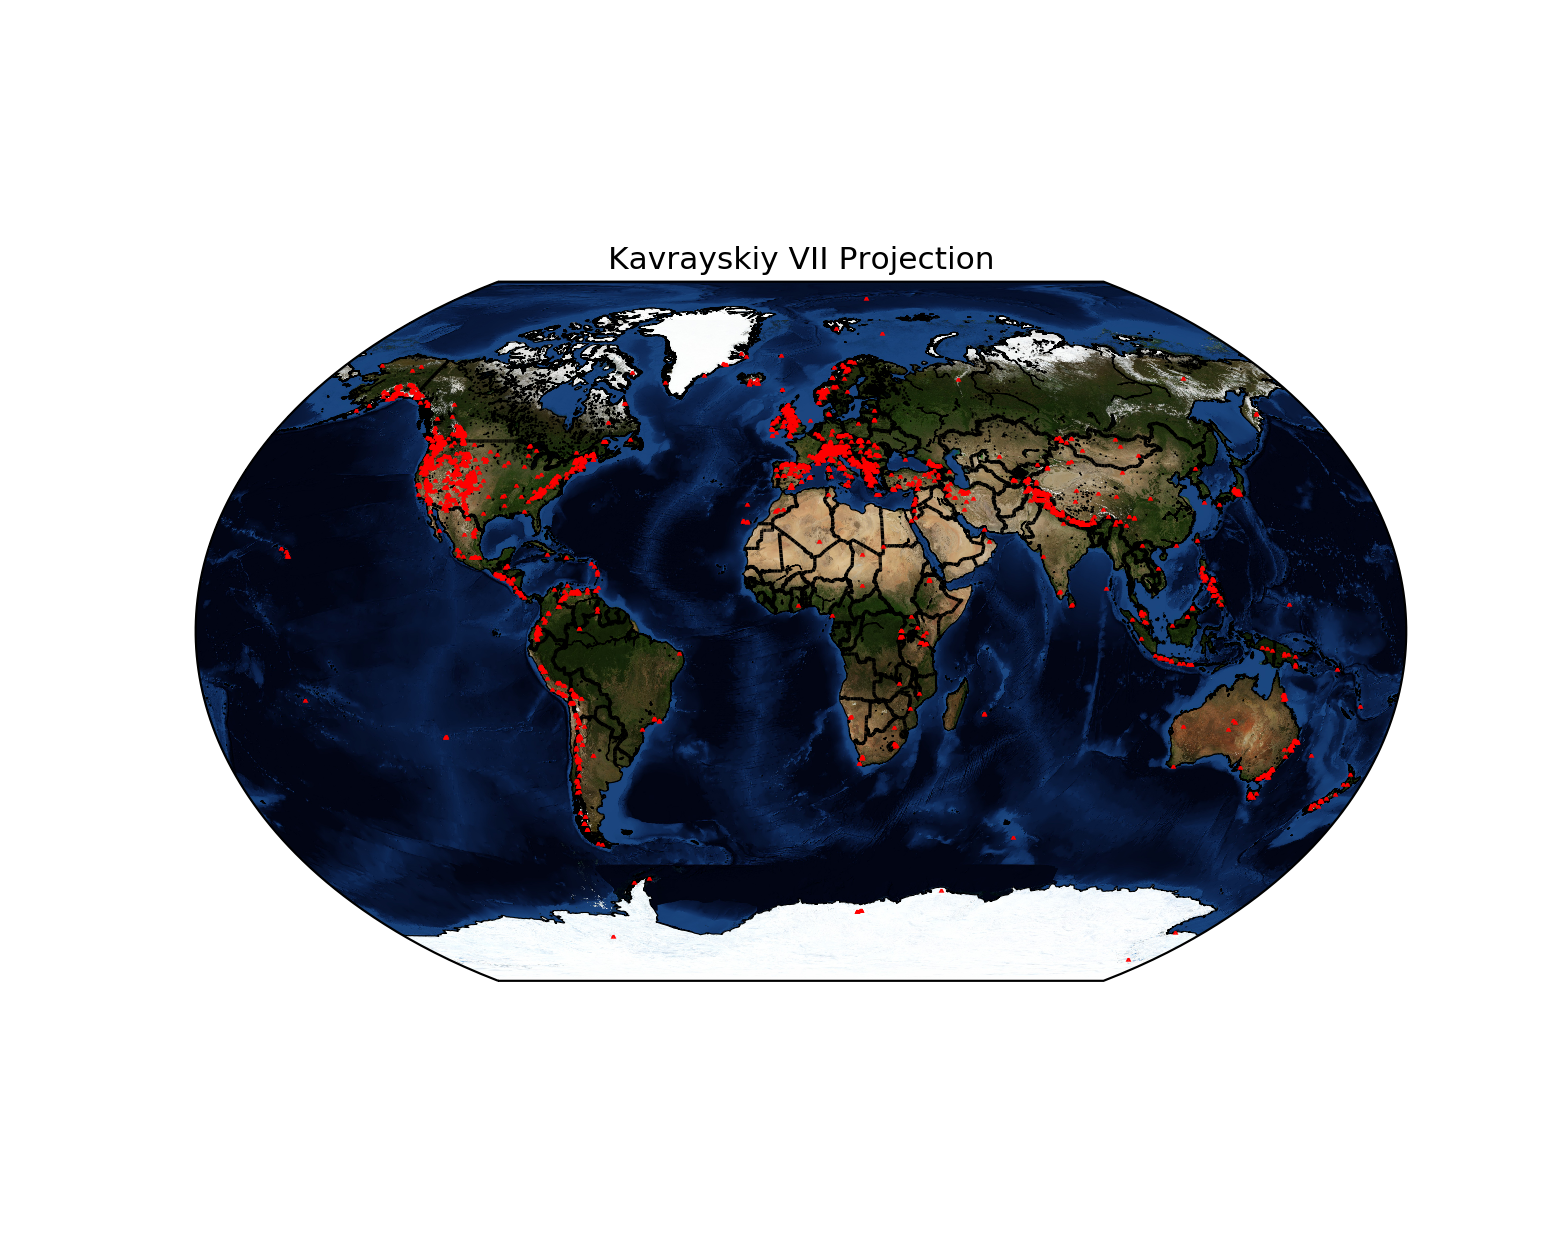

it took  265.712 seconds


In [187]:
fig3 = plt.figure(figsize=(10,8))

# i will want to time it in order to select the resolution and other features
t_1 = time()


# resolution=c,l,h,f  projection='moll','robin','kav7'
m = Basemap(projection='kav7',lon_0=0,resolution='f')

m.drawcountries(linewidth = 1.5)
# m.fillcontinents(color='white',lake_color='white')
m.drawcoastlines(linewidth=0.5)

# Draw an etopo relief image.
m.etopo()

# Draw the NASA ‘Blue Marble’ image.
m.bluemarble()

# Shade the regions of the map that are in darkness at the time specifed by date. 
# date is a datetime instance, assumed to be UTC.
# spec_date =  datetime.now()
# m.nightshade(spec_date, color='k', delta=0.25, alpha=0.5, ax=None, zorder=2)

# Draw a shaded relief image.
# m.shadedrelief()


lons = peaks_df.longitude.tolist()
lats =  peaks_df.latitude.tolist()
x,y = m(lons, lats)
m.plot(x, y, 'r^', markersize=1)

# plt.title('Robinson Projection') # add a title
plt.title('Kavrayskiy VII Projection') # add a title


# some of the peak's names are not encoded in ascii so I would ignore their name
# labels =peaks_df.name_of_peak.map(lambda s: s if (all(ord(c) < 128 for c in s)) else '')
# for label, xpt, ypt in zip(labels, x, y):
#     plt.text(xpt+10000, ypt+5000,  str(label))

#     timing the ruuning time
t_2 = time()
print "it took  {:.3f} seconds".format(t_2-t_1)

#  it took  321.344 seconds
# it took  73.521 seconds
# it took  265.712 seconds

### Zooming in 

<IPython.core.display.Javascript object>


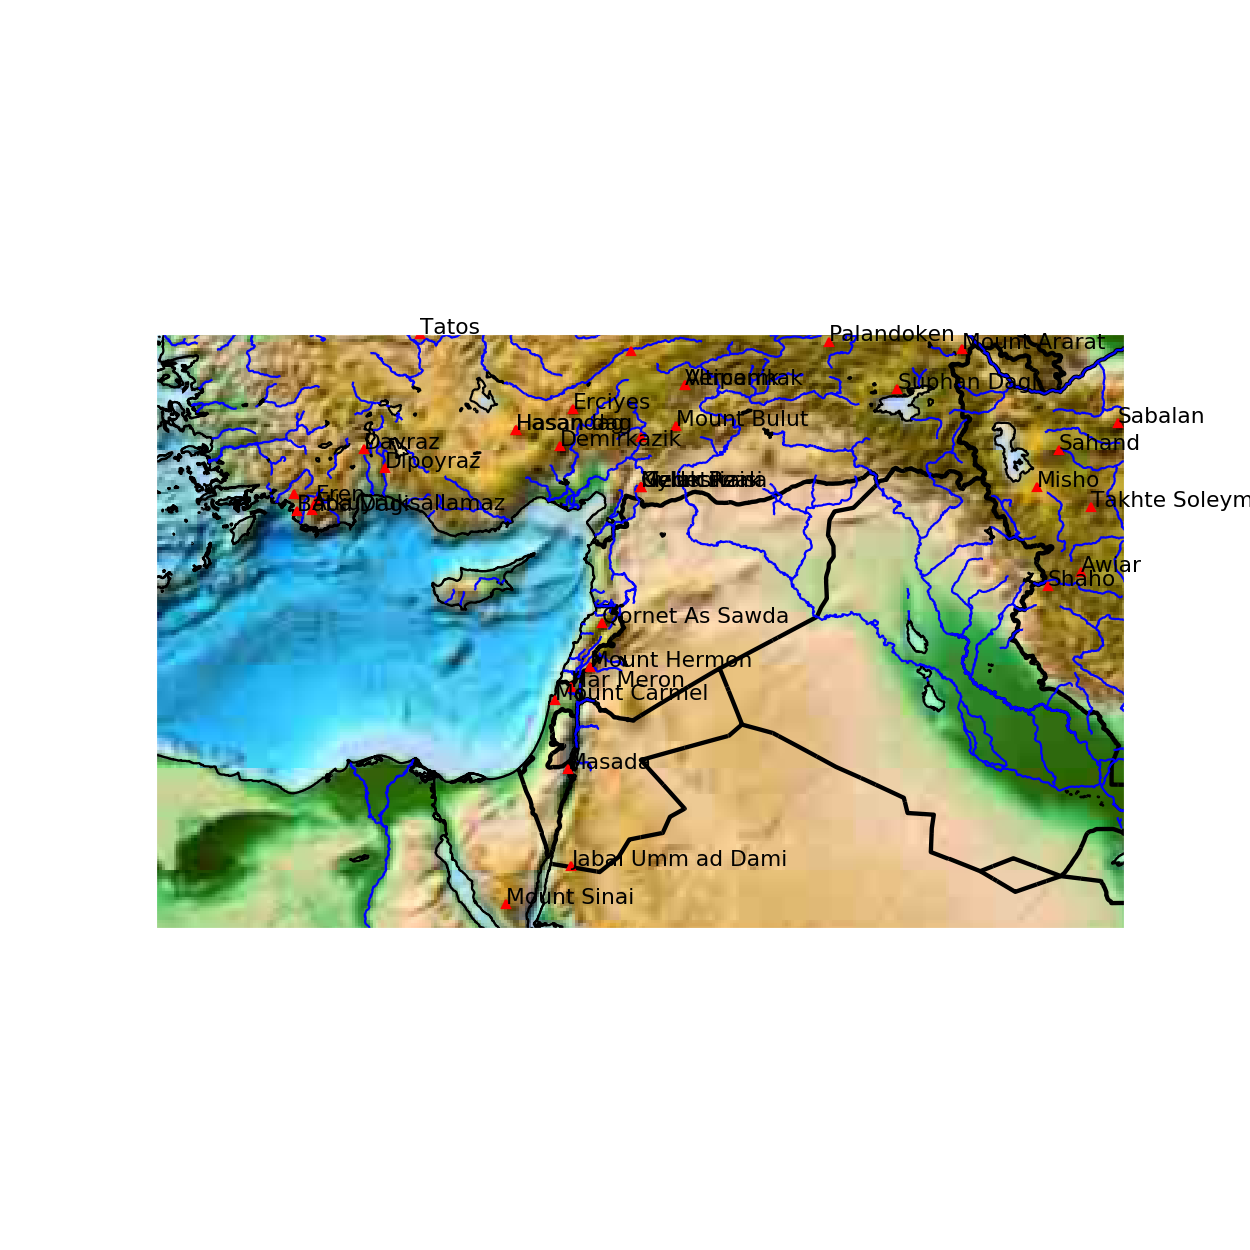

it took  62.869 seconds


In [192]:
fig4 = plt.figure(figsize=(8,8))

# i will want to time it in order to select the resolution and other features
t_1 = time()
# 40-44
# 28-26
ur_lat = 40
ur_lon = 48
ll_lat = 28
ll_lon = 26

lat_indx = (peaks_df['latitude'].between(ll_lat, ur_lat, inclusive=True)== True)
lon_indx = (peaks_df['longitude'].between(ll_lon, ur_lon, inclusive=True)== True)
# peaks_df[lat_indx & lon_indx] .to_csv('lat_indx.csv', encoding='utf-8') 

# # resolution=c,l,h,f  projection='moll','robin','kav7','robin'
m = Basemap(projection='mill',urcrnrlat = ur_lat,urcrnrlon = ur_lon,llcrnrlat = ll_lat,llcrnrlon = ll_lon,resolution='f')

m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')
m.etopo()
# m.bluemarble()
# Draw a shaded relief image.
# m.shadedrelief()
m.drawrivers(linewidth = 1, linestyle='solid', color='b', antialiased=1, ax=None, zorder=None)

lons = peaks_df[lat_indx & lon_indx].longitude.tolist()
lats =  peaks_df[lat_indx & lon_indx].latitude.tolist()
x,y = m(lons, lats)
m.plot(x, y, 'r^', markersize = 4)

# some of the peak's names are not encoded in ascii so I would ignore their name
labels =(peaks_df[lat_indx & lon_indx].name_of_peak.map(lambda s: s if (all(ord(c) < 128 for c in s)) else '')).tolist()
for label, xpt, ypt in zip(labels, x, y):
    plt.annotate(label, xy=(xpt+100, ypt+100))
   
    
#     timing the ruuning time
t_2 = time()
print "it took  {:.3f} seconds".format(t_2-t_1)
# it took  13.763 seconds